# Lugge glacier 1D

This notebook uses the RGI centerline to mesh Lugge in 1D, then interpolates several datasets onto that mesh. Then we write a SSA flow model to forward-model Lugge to steady state from its current real-life configuration. 

## Imports

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from firedrake import *
import pandas as pd
from pyproj import Geod
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

In [2]:
extend_domain = False #extend the domain to allow the glacier to advance? Warning: requires icepack2

In [3]:
import os
os.getcwd()

'/eejit/home/bezu0001/icepack/notebooks/GLIMMER/1D_modelling'

## Set paths and load data

In [4]:
# Paths
base_path = '/eejit/home/bezu0001/'
centerline_path = base_path + 'data/centerlines/RGI2000-v7.0-L-15_south_asia_east/RGI2000-v7.0-L-15_south_asia_east.shp'
outline_path = base_path + 'data/outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'
velocity_path = base_path + 'data/velocity/lugge/MedianVelocity_2006.tif'

# Load data
centerlines = gpd.read_file(centerline_path)
outlines = gpd.read_file(outline_path)
lugge_outline = outlines[outlines['rgi_id'].str.contains("15-09534")].geometry.values[0]
lugge_centerline = centerlines[centerlines.intersects(lugge_outline)].geometry.values[0]

# Part one: mesh the interval and load data
## Create interval mesh of the correct spatial length

In [5]:
# Compute total geodesic length
geod = Geod(ellps="WGS84")
x, y = lugge_centerline.xy

distances = [0] + [geod.inv(x[i], y[i], x[i+1], y[i+1])[2] for i in range(len(x)-1)]
glacier_length = np.sum(distances)
extra_length = float(np.ceil(glacier_length/1e3 + 1)*1e3 - glacier_length) if extend_domain else 0 #extend by ~1km to nearest km
length = glacier_length + extra_length 

if extra_length > 0:
    azimuth, _, _ = geod.inv(x[-2], y[-2], x[-1], y[-1])
    x_new, y_new, _ = geod.fwd(x[-1], y[-1], azimuth, extra_length)
    x = np.append(x, x_new)
    y = np.append(y, y_new)
    distances.append(extra_length)

# Create a Firedrake IntervalMesh with the correct length
n_cells = 100  # Adjust as needed
mesh = IntervalMesh(n_cells, length)

print(f"Created 1D IntervalMesh of length {length:.2f} m with {n_cells} cells.")

Created 1D IntervalMesh of length 8594.88 m with 100 cells.


## Interpolate thickness

In [6]:
# Sample thickness values at centerline points
with rasterio.open(base_path + 'data/bed/Thickness-Farinotti/RGI60-15-02373_latlon.tif') as src:
    thickness_values = np.array(list(src.sample(zip(x, y)))).flatten()

# Compute cumulative distances along the centerline
distances = np.insert(np.cumsum([Geod(ellps="WGS84").inv(x[i], y[i], x[i+1], y[i+1])[2] for i in range(len(x)-1)]), 0, 0)

# Interpolate thickness values onto mesh vertices
vertex_coords = mesh.coordinates.dat.data_ro.flatten()
thickness_interpolated = interp1d(distances, thickness_values, bounds_error=False, fill_value='extrapolate')(vertex_coords)
thickness_interpolated[vertex_coords > glacier_length] = 0
thickness = Function(FunctionSpace(mesh, "CG", 1))
thickness.dat.data[:] = thickness_interpolated 

last_nonzero_thickness = next((v for v in reversed(thickness_interpolated) if v != 0), 0)
print(last_nonzero_thickness)

137.29672241211043


## Interpolate velocity 

In [7]:
output_path = velocity_path.replace('.tif', '_EPSG4326.tif')

try:
    with rasterio.open(output_path) as src:
        velocity_values = np.array(list(src.sample(zip(x, y)))).flatten()
    print('using existing reprojected raster')

except:
    dst_crs = 'EPSG:4326'
    
    with rasterio.open(velocity_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        with rasterio.open(output_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.bilinear
                )
    
    print(f"Reprojected raster saved to: {output_path}")

    with rasterio.open(output_path) as src:
        velocity_values = np.array(list(src.sample(zip(x, y)))).flatten()

# ---- (c) Interpolate onto mesh vertices ----
velocity_interpolated = interp1d(distances, velocity_values, bounds_error=False, fill_value='extrapolate')(vertex_coords)
velocity_interpolated[vertex_coords > glacier_length] = 0

# Create Firedrake function
V = FunctionSpace(mesh, "CG", 1)
velocity = Function(V)
velocity.dat.data[:] = velocity_interpolated

using existing reprojected raster


## Interpolate surface elevations


In [8]:
# Open DEM and sample values at centerline points
with rasterio.open(base_path + 'data/elevation/DEM-SRTMv3/SRTMv3_RGI60-15-02373.tif') as src:
    dem_values = np.array(list(src.sample(zip(x, y)))).flatten()

# Compute cumulative distances along the centerline
distances = np.insert(np.cumsum([Geod(ellps="WGS84").inv(x[i], y[i], x[i+1], y[i+1])[2] for i in range(len(x)-1)]), 0, 0)

# Interpolate DEM values onto mesh vertex coordinates
vertex_coords = mesh.coordinates.dat.data_ro.flatten()
dem_interpolated = interp1d(distances, dem_values, bounds_error=False, fill_value='extrapolate')(vertex_coords)
dem_interpolated[vertex_coords > glacier_length] = 0

last_nonzero_thickness = next((v for v in reversed(thickness_interpolated) if v != 0), 0)
last_nonzero_surface = next((v for v in reversed(dem_interpolated) if v != 0), 0)
dem_interpolated[vertex_coords > glacier_length] = last_nonzero_surface - last_nonzero_thickness

dem = Function(FunctionSpace(mesh, 'CG', 1))
dem.dat.data[:] = dem_interpolated 

## Interpolate surface mass balance

In [9]:
# Load SMB CSV data
smb_data = pd.read_csv(base_path + 'data/smb/prf_glacier_ctl.csv')
altitudes = smb_data[' altitude'].values
smb_values = smb_data['ave_mb'].values

# Interpolation function: altitude vs SMB
smb_interp = interp1d(altitudes, smb_values, bounds_error=False, fill_value='extrapolate')
# Interpolate SMB onto mesh vertices based on vertex elevations
vertex_elevations = dem.dat.data_ro
smb_on_mesh = smb_interp(vertex_elevations)
smb = Function(FunctionSpace(mesh, "CG", 1))
smb.dat.data[:] = smb_on_mesh

## And plot

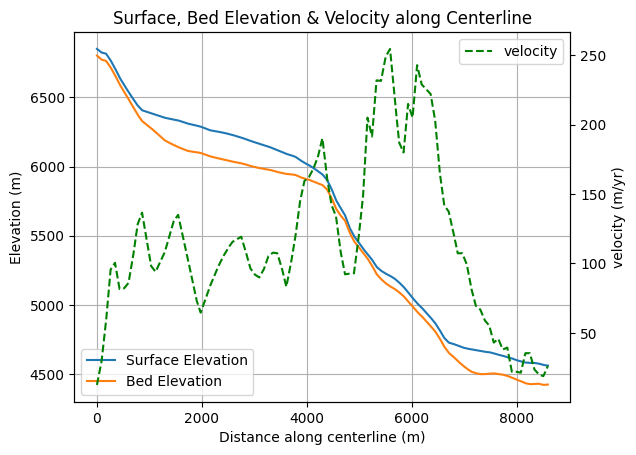

In [10]:
# Sample elevation, thickness, and SMB along the mesh
X = np.array([(x,) for x in np.linspace(0, length, int(length))])
elevation_ref = np.array(dem.at(X, tolerance=1e-10))
thickness_ref = np.array(thickness.at(X, tolerance=1e-10))
bed_ref = elevation_ref - thickness_ref
smb_ref = np.array(smb.at(X, tolerance=1e-10))
velocity_ref = velocity.at(X, tolerance = 1e-10)

# Plot
fig, ax1 = plt.subplots()
ax1.plot(X.flatten(), elevation_ref, label='Surface Elevation')
ax1.plot(X.flatten(), bed_ref, label='Bed Elevation')
ax1.set_xlabel('Distance along centerline (m)')
ax1.set_ylabel('Elevation (m)')
ax1.grid(True)
ax1.legend(loc='lower left')

# Add twin axis for SMB
ax2 = ax1.twinx()
ax2.plot(X.flatten(), velocity_ref, color='green', linestyle='dashed', label='velocity')
ax2.set_ylabel('velocity (m/yr)')
ax2.legend(loc='upper right')

plt.title('Surface, Bed Elevation & Velocity along Centerline')
plt.show()

# Part 2: Flow modeling

In [11]:
import icepack, icepack2
from icepack.constants import ice_density as ρ_I, gravity as g
from icepack.utilities import itemgetter
from icepack2 import model
import tqdm

In [12]:
T = 273.15 - 0 #ice temperature (K), assumed isothermal
A = Constant(icepack.rate_factor(T))
H = thickness.copy(deepcopy = True)
s = dem.copy(deepcopy = True)

Q = FunctionSpace(mesh, 'CG', 1)
x, = SpatialCoordinate(Q)
u = Function(Q).project(Constant(velocity_ref[0]))

u_0 = u.copy(deepcopy = True)
H_0 = H.copy(deepcopy = True)
s_0 = s.copy(deepcopy = True)
bed = Function(Q).project(s_0 - H_0)

terminus_coordinate = glacier_length

## SIA solver from icepack

In [13]:
opts = {
    'dirichlet_ids' : [1] 
}

flow_model = icepack.models.ShallowIce()
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

## Solve the system iteratively

Right now this is modeled to steady state under the assumption of zero mass balance. Using the actual SMB data, the model reaches zero thickness in places and fails before reaching steady state.  

In [14]:
Δt = 1/10
num_years = 10
num_timesteps = int(num_years/Δt)

thickness_evolution, velocity_evolution = [], []

for step in tqdm.trange(num_timesteps):
    
    u = flow_solver.diagnostic_solve(velocity = u, thickness = H, surface = s, fluidity = A)
    H = flow_solver.prognostic_solve(Δt, thickness = H, velocity = u, thickness_inflow = H_0, accumulation = Constant(0))
    s.project(bed + H)
    
    # if step % int(1/Δt) == 0: #save results every year
    #     thickness_evolution.append(H.at(X, tolerance = 1e-10))
    #     velocity_evolution.append(u.at(X, tolerance = 1e-10))

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.97it/s]


## Plot results

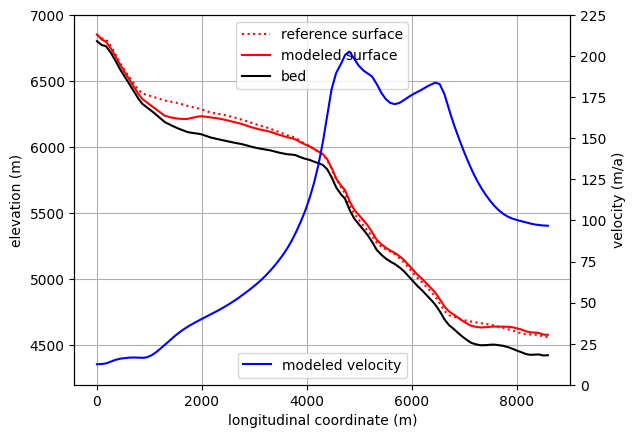

In [15]:
plt.figure()
plt.plot(elevation_ref, color = 'red', linestyle = 'dotted', label = 'reference surface')
plt.plot(s.at(X, tolerance = 1e-10), color = 'red', linestyle = 'solid', label = 'modeled surface')
plt.plot(bed.at(X, tolerance = 1e-10), color = 'k', linestyle = 'solid', label = 'bed')
plt.grid()
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.ylim(4200, 7000)
plt.legend(loc = 'upper center')

plt.twinx()
# plt.plot(velocity_ref, color = 'blue', linestyle = 'dotted', label = 'reference velocity')
plt.plot(u.at(X, tolerance = 1e-10), color = 'blue', label = 'modeled velocity')
plt.ylabel('velocity (m/a)')
plt.ylim(0, 225)

plt.legend(loc = 'lower center')
plt.show()